In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,RobustScaler,MinMaxScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


#clustering
from scipy.spatial.distance import cdist,pdist
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

In [43]:
data = pd.read_csv('marketing_data.csv')

In [44]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,"$66,476.00",0,1,3/7/13,99,372,...,11,4,0,0,0,0,0,0,0,US
2236,5263,1977,2n Cycle,Married,"$31,056.00",1,0,1/22/13,99,5,...,3,8,0,0,0,0,0,0,0,SP
2237,22,1976,Graduation,Divorced,"$46,310.00",1,0,12/3/12,99,185,...,5,8,0,0,0,0,0,0,0,SP
2238,528,1978,Graduation,Married,"$65,819.00",0,0,11/29/12,99,267,...,10,3,0,0,0,0,0,0,0,IND


In [45]:
data.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
 Income                24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Complain                0
Country                 0
dtype: int64

**Data Cleansing**

In [46]:
todayy = pd.Timestamp('28/2/21')
data['Dt_Customer']= pd.to_datetime(data['Dt_Customer'])
data['Dt_Customer'] = (todayy - data['Dt_Customer']).dt.days

In [47]:
data['Dt_Customer']

0       2449
1       2450
2       2483
3       2485
4       2518
        ... 
2235    2915
2236    2959
2237    3009
2238    3013
2239    3102
Name: Dt_Customer, Length: 2240, dtype: int64

In [7]:
data.rename(columns={' Income ':'Income'},inplace=True)

In [8]:
data['Income']=data['Income'].str.replace('[$,]','').astype(float)

In [9]:
imp_num=SimpleImputer(strategy='mean')
data['Income']= imp_num.fit_transform(data[['Income']])
data.isna().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Response               0
Complain               0
Country                0
dtype: int64

**RFM**

RFM segmentation berdasarkan kebiasaan cust.(Spending, cunsumption habbit, product/service usage, previously purchased product)

>- Recency (R): Terakhir kali cust membeli product.
>- Frequency (F): Frequency dari cust. melakukan pembelian
>- Monetary Value(M): Jumlah seluruh nilai belanja dari cust(karena tidak ada harga pada dataset maka akan dihitung dari penjumlahan product yang dibeli tanpa mengalikan dengan harga product)

Akan dibuat 2 variable tambahan :

>- Variable __*Spending*__ Penjumlahan dari 6 Product yang telah dibelu.(Monetary karna bsa dihitung nilai dr produk yg dibeli)
>- Variable __*Transactions*__ Penjumlahan dari berapa kali customer beli product (Frequency seberapa sering dia keep in touch dg company)


**Alur pengerjaan:**
1. Pertama mencari nilai R&F&M, setelah didapat nilai Recency, Frequency dan Monetary setiap customer maka akan dicari banyaknya cluster dari masing-masing column RFM menggunakan metode Elbow dan Silloutte. 
2. Pengecekan ulang jumlah cluster jika menggunakan Recency, Frequency dan Monetary sekaligus.
3. Setelah mendapatkan jumlah cluster yang tepat maka akan dibuat RFM Class dimana berisi penjumlahan score cluster untuk mendapatkan jumlah segmentasi yang tepat.

In [10]:
data['Spending']=data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']
data['Transactions']=data['NumWebPurchases']+data['NumCatalogPurchases']+data['NumStorePurchases']
data=data[['ID','Spending','Transactions','Recency','Dt_Customer']]
data = data[data['Transactions'] > 1] # customers with repeated purchases, implying number of transactions must be at least 2
data = data[data['Spending'] > 0]

In [11]:
#statistical summary
print("Summary of the last 2 years spending")
print("Number of transactions: ", data['Transactions'].sum())
print("Total sales: ",data['Spending'].sum())
print("Number of customers:", data['ID'].nunique())

Summary of the last 2 years spending
Number of transactions:  28077
Total sales:  1354764
Number of customers: 2228


# *Recency*

In [12]:
recency = data[['ID','Recency']]
recency

,ID,Recency
0,1826,0
1,1,0
2,10476,0
3,1386,0
4,5371,0
...,...,...
2235,10142,99
2236,5263,99
2237,22,99
2238,528,99


# *Frequency*

In [13]:
frequency = data[['ID','Spending']]
frequency

,ID,Spending
0,1826,1190
1,1,577
2,10476,251
3,1386,11
4,5371,91
...,...,...
2235,10142,689
2236,5263,55
2237,22,309
2238,528,1383


# *Monatary*

In [14]:
monetary = data[['ID','Transactions']]
monetary

,ID,Transactions
0,1826,14
1,1,17
2,10476,10
3,1386,3
4,5371,6
...,...,...
2235,10142,18
2236,5263,4
2237,22,12
2238,528,19


In [15]:
temp = recency.merge(frequency,on='ID')
RFM_Segmentation  = temp.merge(monetary,on='ID')
RFM_Segmentation.columns = ['ID','Recency','Frequency','Monetary']
RFM_Segmentation

,ID,Recency,Frequency,Monetary
0,1826,0,1190,14
1,1,0,577,17
2,10476,0,251,10
3,1386,0,11,3
4,5371,0,91,6
...,...,...,...,...
2223,10142,99,689,18
2224,5263,99,55,4
2225,22,99,309,12
2226,528,99,1383,19


# Cari Jumlah Cluster Dari Column Recency,Frequency,Monetary

**Cari Cluster Recency**

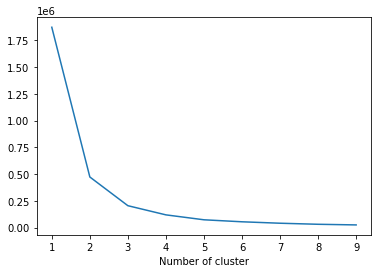

In [16]:
#Elbow Method
sse={}
tx_recency = RFM_Segmentation[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=0).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Text(0, 0.5, 'silloutte score')

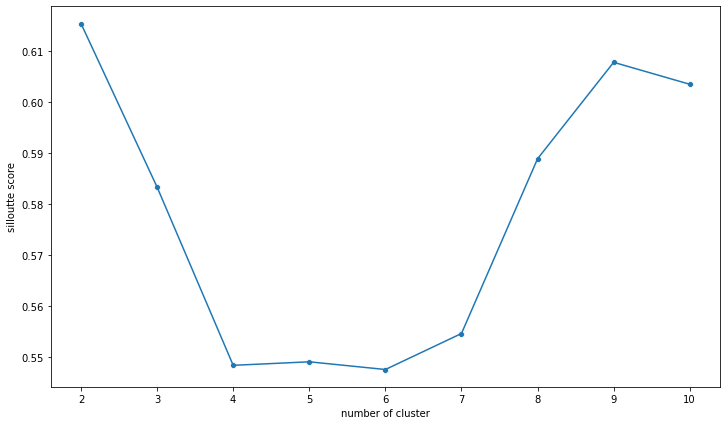

In [17]:
#silhouette
kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(tx_recency)

labels=kmeans.labels_
silhouette_score(tx_recency,labels,metric='euclidean')

s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(tx_recency)
    labels=kmeans.labels_
    s_score.append(silhouette_score(tx_recency,labels,metric='euclidean'))
    
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')

*Berdasarkan Elbow method dan sillhoutte method maka Recency memiliki 2 cluster*

In [18]:
#buat column Recency Cluster
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(RFM_Segmentation[['Recency']])
RFM_Segmentation['RecencyCluster'] = kmeans.labels_

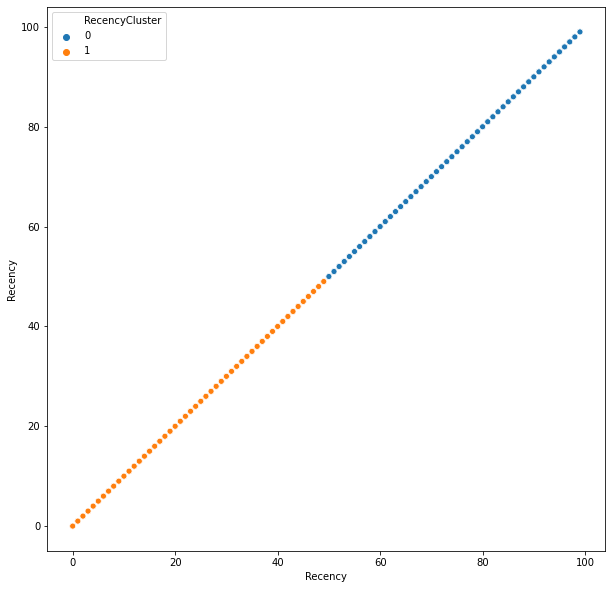

In [19]:
#visualisasi Recency cluster
plt.figure(figsize=(10,10))

sns.scatterplot(x='Recency', y ='Recency',data=RFM_Segmentation,hue='RecencyCluster')
plt.show()

**Cari Cluster dari Frequency**`

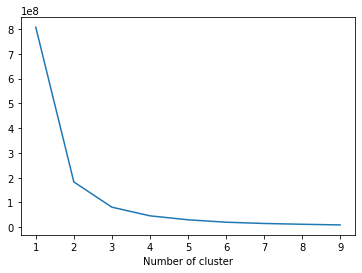

In [20]:
#Elbow Method
sse={}
tx_Frequency = RFM_Segmentation[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=0).fit(tx_Frequency)
    tx_Frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Text(0, 0.5, 'silloutte score')

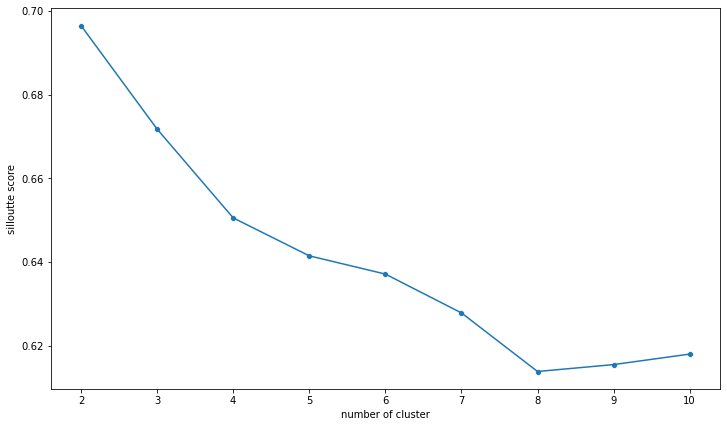

In [21]:
#silhouette
kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(tx_Frequency)

labels=kmeans.labels_
silhouette_score(tx_Frequency,labels,metric='euclidean')

s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(tx_Frequency)
    labels=kmeans.labels_
    s_score.append(silhouette_score(tx_Frequency,labels,metric='euclidean'))
    
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')

*Berdasarkan Elbow method dan sillhoutte method maka Frequency memiliki 2 cluster*

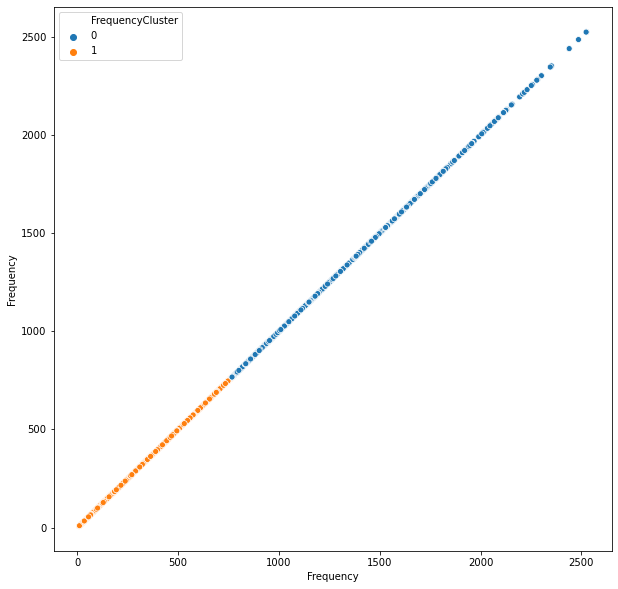

In [22]:
#buat column Frequency Cluster
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(RFM_Segmentation[['Frequency']])
RFM_Segmentation['FrequencyCluster'] = kmeans.labels_

#visualisasi Frequency cluster
plt.figure(figsize=(10,10))

sns.scatterplot(x='Frequency', y ='Frequency',data=RFM_Segmentation,hue='FrequencyCluster')
plt.show()


In [23]:
#utk membalik nilai cluster, karena semakin banyak frequency, semakin bagus
RFM_Segmentation['FrequencyCluster']=np.where(RFM_Segmentation['FrequencyCluster']==1,0,1)

**Cari Cluster dari Monetary**

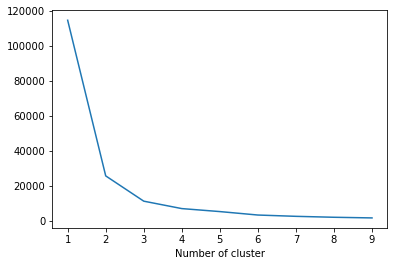

In [24]:
#Elbow Method
sse={}
tx_Monetary = RFM_Segmentation[['Monetary']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=0).fit(tx_Monetary)
    tx_Monetary["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Text(0, 0.5, 'silloutte score')

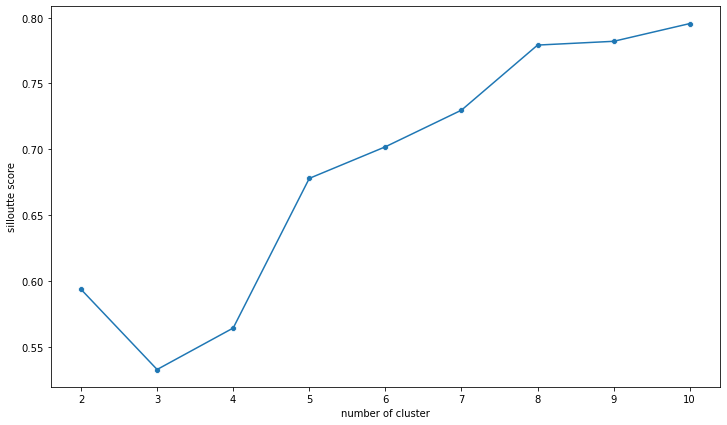

In [25]:
#silhouette
kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(tx_Monetary)

labels=kmeans.labels_
silhouette_score(tx_Monetary,labels,metric='euclidean')

s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(tx_Monetary)
    labels=kmeans.labels_
    s_score.append(silhouette_score(tx_Monetary,labels,metric='euclidean'))
    
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')

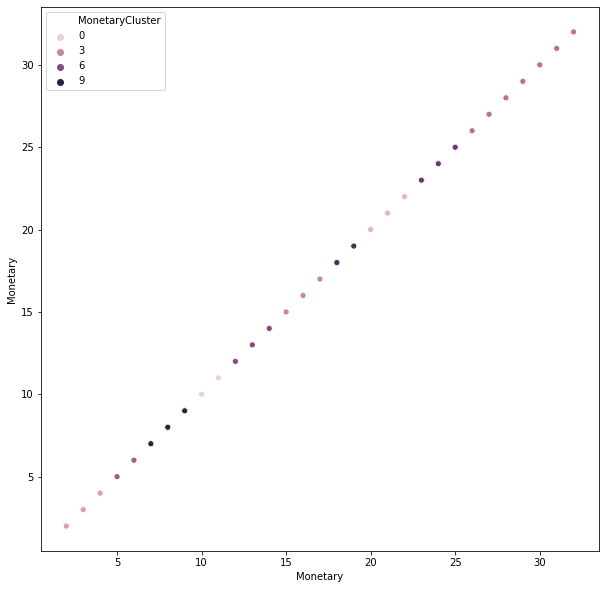

In [26]:
#buat column Monetary Cluster
kmeans = KMeans(n_clusters=10,random_state=0)
kmeans.fit(RFM_Segmentation[['Monetary']])
RFM_Segmentation['MonetaryCluster'] = kmeans.labels_

#visualisasi Monetary cluster
plt.figure(figsize=(10,10))

sns.scatterplot(x='Monetary', y ='Monetary',data=RFM_Segmentation,hue='MonetaryCluster')
plt.show()


*Berdasarkan Elbow method memiliki 2 cluster sedangkan sillhoutte score  Monetary memiliki 10 cluster(dan jumlah cluster akan terus bertambah jika range n_cluster diperbesar) hal ini menunjukkan* **tidak adanya cluster pada Monetary** *yang bisa saja disebabkan karena tidak adanya data harga dari setiap product.*

In [27]:
RFM_Segmentation

,ID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster
0,1826,0,1190,14,1,1,6
1,1,0,577,17,1,0,3
2,10476,0,251,10,1,0,0
3,1386,0,11,3,1,0,2
4,5371,0,91,6,1,0,5
...,...,...,...,...,...,...,...
2223,10142,99,689,18,0,0,8
2224,5263,99,55,4,0,0,2
2225,22,99,309,12,0,0,6
2226,528,99,1383,19,0,1,8


# Pengecekan Jumlah Cluster dengan cara penggabungan RFM

In [28]:
X=RFM_Segmentation[['Recency','Frequency','Monetary']]

In [29]:
X

,Recency,Frequency,Monetary
0,0,1190,14
1,0,577,17
2,0,251,10
3,0,11,3
4,0,91,6
...,...,...,...
2223,99,689,18
2224,99,55,4
2225,99,309,12
2226,99,1383,19


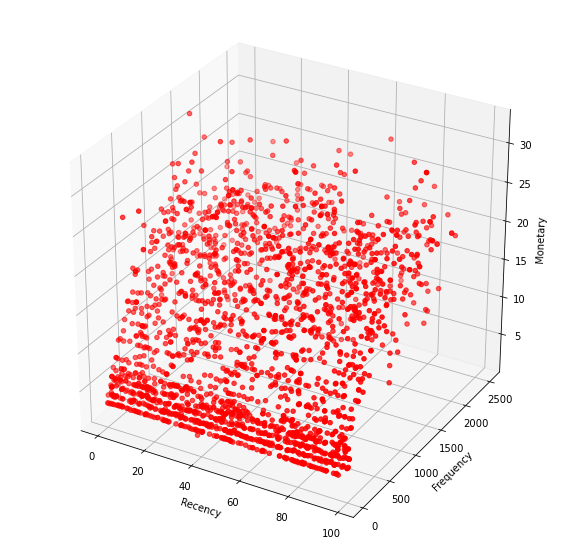

In [30]:
fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(111,projection='3d')

x=X['Recency']
y=X['Frequency']
z=X['Monetary']
ax.scatter(x,y,z,c='r',marker='o')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

*elbow method*

Text(0, 0.5, 'average within sum square')

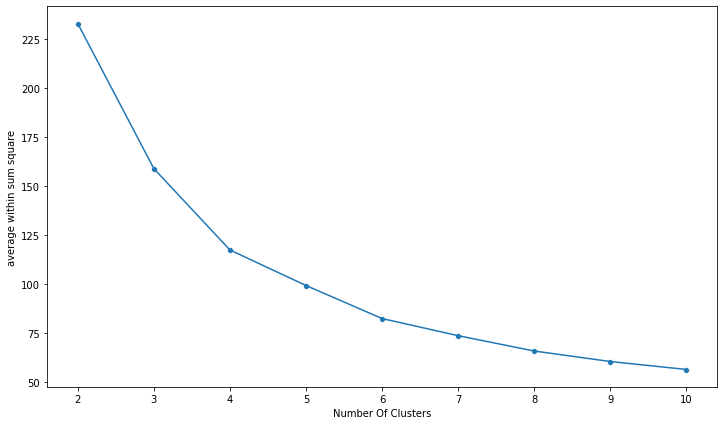

In [31]:
#clustering variation
number_of_cluster = range(2,11)
clusterings=[KMeans(n_clusters=k,random_state=0).fit(X) for k in number_of_cluster]
centroids= [k.cluster_centers_ for k in clusterings]

#within sum square, utk cari jarak 
D_k=[cdist(X,cent,'euclidean') for cent in centroids]
cIdx=[np.argmin(D,axis=1) for D in D_k]
dist=[np.min(D,axis=1)for D in D_k]
avg_withinSS=[sum(d)/X.shape[0] for d in dist]

#visualisasi
plt.figure(figsize=(12,7))
sns.lineplot(number_of_cluster,avg_withinSS)
sns.scatterplot(number_of_cluster,avg_withinSS)

plt.xticks(number_of_cluster)

plt.xlabel('Number Of Clusters')
plt.ylabel('average within sum square')

*Elbow method menunjukkan adanya Clustering sebanyak 3/4*

Text(0, 0.5, 'silloutte score')

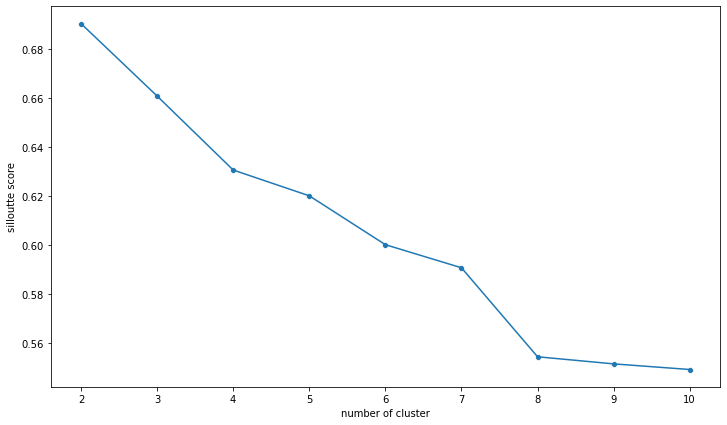

In [32]:
#Sillhoutte
s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(X)
    labels=kmeans.labels_
    s_score.append(silhouette_score(X,labels,metric='euclidean'))
    
#viasulisasi
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')

*Berdasarkan Sillhoutte Score ada 2 Cluster*

**Final Result menggunakan 2 cluster**

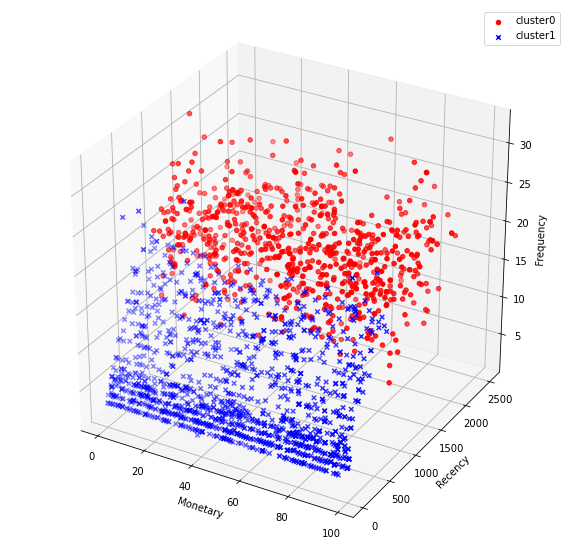

In [33]:
kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(X)
RFM_Segmentation['cluster']=kmeans.labels_

#visualisasi
fig=plt.figure(figsize=(10,10))
ax= fig.add_subplot(111,projection='3d')

ax.scatter(X['Recency'][RFM_Segmentation['cluster']==0],X['Frequency'][RFM_Segmentation['cluster']==0],X['Monetary'][RFM_Segmentation['cluster']==0], c='r', marker='o')
ax.scatter(X['Recency'][RFM_Segmentation['cluster']==1],X['Frequency'][RFM_Segmentation['cluster']==1],X['Monetary'][RFM_Segmentation['cluster']==1], c='b', marker='x')


ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_xlabel('Monetary')

plt.legend(('cluster0','cluster1'))

plt.show()

**SUMMARY**

Pada saat dibandingkan dengan 2 metode berbeda ternyata sama-sama memiliki 2 cluster sehingga akan dipilih cluster sebanyak 2. dan Segmentasi akan berdasarkan nilai RF(Recency Frequency) Score, karena Monetary Tidak memiliki cluster dan hanya digunakan untuk aggregate

# **Membuat RF Score**

In [34]:
RFM_Segmentation['RF_Score'] = RFM_Segmentation['RecencyCluster'] + RFM_Segmentation['FrequencyCluster']
RFM_Segmentation.groupby('RF_Score')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
RF_Score,,,
0,74.567919,211.819364,8.507225
1,42.070130,609.439827,12.581818
2,24.081365,1323.574803,20.099738


In [35]:
#penamaan Clustering berdasar unique nilai RFM
def rfm_label(df):
    if df['RF_Score'] == 2:
        return 'Priority'
    elif ((df['RF_Score'] == 1)):
        return 'Loyal'
    else:
        return 'Need Attention'

In [36]:
RFM_Segmentation['RFM_Label'] = RFM_Segmentation.apply(rfm_label, axis=1)
RFM_Segmentation

,ID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,cluster,RF_Score,RFM_Label
0,1826,0,1190,14,1,1,6,0,2,Priority
1,1,0,577,17,1,0,3,1,1,Loyal
2,10476,0,251,10,1,0,0,1,1,Loyal
3,1386,0,11,3,1,0,2,1,1,Loyal
4,5371,0,91,6,1,0,5,1,1,Loyal
...,...,...,...,...,...,...,...,...,...,...
2223,10142,99,689,18,0,0,8,1,0,Need Attention
2224,5263,99,55,4,0,0,2,1,0,Need Attention
2225,22,99,309,12,0,0,6,1,0,Need Attention
2226,528,99,1383,19,0,1,8,0,1,Loyal


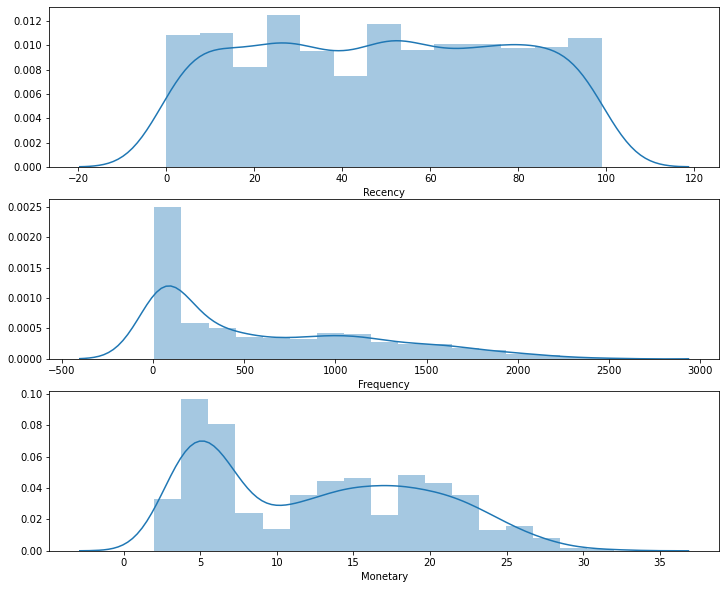

In [37]:
#plot distribution
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(RFM_Segmentation['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(RFM_Segmentation['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(RFM_Segmentation['Monetary'])
# Show the plot
plt.show()

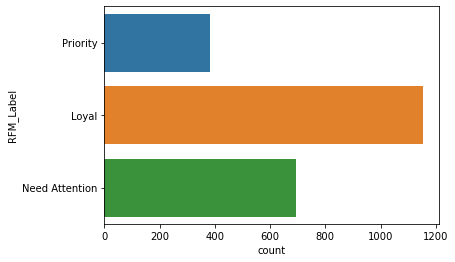

In [38]:
sns.countplot(y='RFM_Label',data=RFM_Segmentation)

Segmentasi di Dominasi oleh Segmen *Loyal*

In [39]:
#analyss persegment
# Calculate average values for each RFM segment, and return a size of each segment 
RFM_interpret = RFM_Segmentation.groupby('RFM_Label').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
}).round(1)
# Print the aggregated dataset
RFM_interpret

Recency Frequency Monetary      
                  mean      mean     mean count
RFM_Label                                      
Loyal             42.1     609.4     12.6  1155
Need Attention    74.6     211.8      8.5   692
Priority          24.1    1323.6     20.1   381

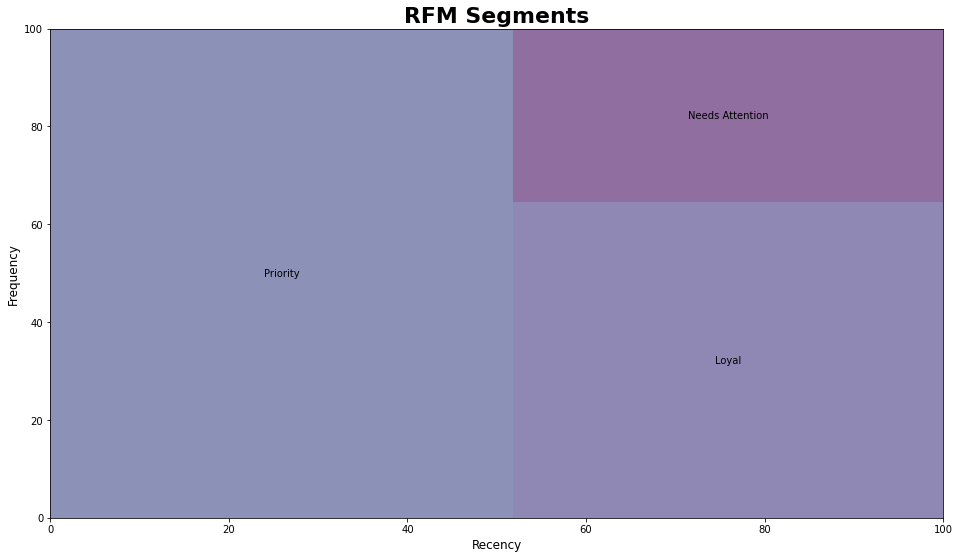

In [40]:
#segment vizual R and F
#monetary just for agg
import squarify
RFM_interpret.columns = ['Recencymean','Frequencymean', 'Monetarymean','Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=RFM_interpret['Count'], 
              label=['Priority', 'Loyal','Needs Attention'], alpha=.6 )
plt.title("RFM Segments",fontsize=22,fontweight="bold")
ax.set_xlabel('Recency',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
plt.axis('on')
plt.show()

**INTERPRETASI**

*Penyebutan Customer adalah untuk pelanggan yang sudah menjadi member company*

**Priority**
>Cust yang paling sering berbelanja (recency rendah), paling sering keep intouch dengan company melalui pembelian product dari beberapa market place serta yang paling banyak spending money ke company.

>Saran : Untuk segmentasi Priority lebih baik dilakukan treatment seperti memberikan reward lebih, memberikan info serta tester pada setiap product yang baru, karena biasanya mereka ikut membantu mempromosikan kepada orang terdekat. Serta dengan adanya reward lebih untuk segmen priority akan  menarik customer yang berada dibawah Priority untuk meningkatkan membership/segmen

**Loyal**
>Cust yang belum lama berbelanja product kita,dan nilai memiliki nilai frequency serta monetary yang cukup. Customer ini berada dibawah segmen Priority,Biasanya mereka berbelanja hanya jika ada discount ataupun kebutuhan mendesak. jika dilihat, segmen Loyal sangat banyak sehingga mengartikan bahwa loyal mendominasi segmen dari cust. 

> Saran : untuk segmentasi Loyal lebih baik cust diberikan discount kecil namun dalam frequency sering terhadap beberapa produk secara bergantian agar meningkatkan frequency dan monetary.

**Needs Attention**
>Cust yang sudah lama tidak membeli product kita. Segmen ini harus lebih diperhatikan karena segmen ini memiliki kemungkinan besar untuk putus member/ tidak memperpanjang member company, yang dapat berakibat menurunnya penjualan dalam jangka panjang(karna branding kurang kuat dengan sedikit customer

>Saran : Meminta saran kepada segmen ini mengenai apa yang kurang dari product yang dijual ataupun dari segi pelayanan. Karena biasanya cust berpaling karena sudah tidak ada kecocokan dengan product/pelayanan, Serta memberikan Discount khusus untuk segmen ini

**SUMMARY SUGGESTION**
Segmentasi ini dibuat untuk mengetahui perlakuan yang tepat kepada setiap customer dengan tujuan menjaga Customer membership, setelah mengetahui segmen dari setiap customer maka company bisa mengadakan tingkatan membership berdasarkan Segmen yang sudah ada dan memberikan reward yang berbeda. Serta dapat diadakan challenge untuk menaikkan membership, agar customer saling berkompetisi untuk berbelanja.

In [41]:
RFM_Segmentation

,ID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,cluster,RF_Score,RFM_Label
0,1826,0,1190,14,1,1,6,0,2,Priority
1,1,0,577,17,1,0,3,1,1,Loyal
2,10476,0,251,10,1,0,0,1,1,Loyal
3,1386,0,11,3,1,0,2,1,1,Loyal
4,5371,0,91,6,1,0,5,1,1,Loyal
...,...,...,...,...,...,...,...,...,...,...
2223,10142,99,689,18,0,0,8,1,0,Need Attention
2224,5263,99,55,4,0,0,2,1,0,Need Attention
2225,22,99,309,12,0,0,6,1,0,Need Attention
2226,528,99,1383,19,0,1,8,0,1,Loyal
